In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import joblib
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
datanums = sum([len(joblib.load(i)) for i in glob('cluster/*pickle')])

In [3]:
def gen_lc(trainsize,testsize):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]
        
    radius_range_dirs = []
    for i in glob('cluster/*.*'):
        try:
            radstr = float(os.path.basename(i))
            # if radstr>=1.4:
            radius_range_dirs.append(os.path.basename(i))
        except:
            continue
    
    radius_range = sorted(radius_range_dirs)
    
    train_ind,test_ind=radius_range[0::2],radius_range[1::2]
    
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind,train_size=trainsize, test_size=testsize, random_state=42)
    
    print(len(train_ind),len(test_ind))
    
    
    train = []
    test = []
    
    
    
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    
    
    for k in train_ind:
        rad = f"{k:.2f}"
        traindf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        # traindf = traindf[traindf['Pair_Energies'].abs()>=1e-7]
        train.append(traindf)
        recover_train.append((rad,traincnt,len(traindf)))
        traincnt+=1
            
    for l in test_ind:
        rad = f"{l:.2f}"
        testdf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        # testdf = testdf[testdf['Pair_Energies'].abs()>=1e-7]
        test.append(testdf)                    
        recover_test.append((rad,testcnt,len(testdf)))
        testcnt+=1
    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': 'h$_{p}^{0}$',
    'h$_{pp}^{1}$': 'h$_{p}^{1}$',
    'h$_{pp}^{2}$': 'h$_{p}^{2}$',
    'h$_{pp}^{3}$': 'h$_{p}^{3}$',
    'h$_{rr}^{0}$': 'h$_{r}^{0}$',
    'h$_{rr}^{1}$': 'h$_{r}^{1}$',
    'h$_{rr}^{2}$': 'h$_{r}^{2}$',
    'h$_{rr}^{3}$': 'h$_{r}^{3}$'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    
    kwargs = dict(pd.read_excel("iron_VDZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    
    
    for i in traincorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    
    
    for i in testcorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    testcorrE2.reset_index(inplace=True)
    traincorrE2.reset_index(inplace=True)    
    
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [4]:

def plot(data,trainsize):
    pair_r2 = []
    pair_mae = []
    corr_r2 = []
    corr_mae = []
    for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
        traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
        traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']
    
        testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
        testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
        
        pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
        pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))
    
        corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
        corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))
    
    dfpair_r2 = pd.DataFrame(pair_r2,columns=['Train Size', "Train", "Test"])
    dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Train Size', "Train", "Test"])
    dfpair_mae = pd.DataFrame(pair_mae,columns=['Train Size', "Train", "Test"])
    dfcorr_mae = pd.DataFrame(corr_mae,columns=['Train Size', "Train", "Test"])
    # dfcorr_r2.to_excel('corrr2.xlsx')
    print(dfcorr_r2)
    fig, ax = plt.subplots(2,2,sharex=True)
    sns.lineplot(dfpair_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][0])
    sns.lineplot(dfcorr_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][1],markers='x')
    ax[0][0].set_xlim(0,700)
    ax[0][1].set_xlim(0,700)
    ax[0][0].set_ylim(-.74,1.1)
    ax[0][1].set_ylim(-.74,1.1)
    ax[0][0].set_ylabel("R$^{2}$")
    ax[0][1].set_ylabel("R$^{2}$")
    sns.lineplot(dfpair_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][0])
    ax[1][0].set_ylim(0,0.25)
    sns.lineplot(dfcorr_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][1])
    ax[1][1].set_ylim(0,8)
    ax[1][0].set_ylabel("MAE (mE$_{h}$)")
    ax[1][1].set_ylabel("MAE (mE$_{h}$)")
    plt.tight_layout()
    # plt.savefig('images/learning_curves.png',dpi=300,bbox_inches='tight')

In [5]:
.1 * 500

50.0

In [6]:
ranges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]

data = []
for i in ranges:
    # print(i,j)
    data.append((int(i * datanums),gen_lc(i,0.1)))
plt.show()

66 66
R2: 0.9947,0.9354
RMSE (mEh): 0.1507,0.5302
132 66
R2: 0.9960,0.9550
RMSE (mEh): 0.1307,0.4426
198 66
R2: 0.9967,0.9649
RMSE (mEh): 0.1191,0.3909
264 66
R2: 0.9973,0.9666
RMSE (mEh): 0.1079,0.3809
330 66
R2: 0.9975,0.9739
RMSE (mEh): 0.1037,0.3366
396 66
R2: 0.9978,0.9773
RMSE (mEh): 0.0965,0.3142
461 66
R2: 0.9980,0.9773
RMSE (mEh): 0.0924,0.3145
528 66
R2: 0.9982,0.9819
RMSE (mEh): 0.0873,0.2807
594 66
R2: 0.9983,0.9846
RMSE (mEh): 0.0856,0.2588


66 66
R2: 0.9947,0.9354
RMSE (mEh): 0.1507,0.5302
132 66
R2: 0.9960,0.9550
RMSE (mEh): 0.1307,0.4426
198 66
R2: 0.9967,0.9649
RMSE (mEh): 0.1191,0.3909
264 66
R2: 0.9973,0.9666
RMSE (mEh): 0.1079,0.3809
330 66
R2: 0.9975,0.9739
RMSE (mEh): 0.1037,0.3366
396 66
R2: 0.9978,0.9773
RMSE (mEh): 0.0965,0.3142
461 66
R2: 0.9980,0.9773
RMSE (mEh): 0.0924,0.3145
528 66
R2: 0.9982,0.9819
RMSE (mEh): 0.0873,0.2807
594 66
R2: 0.9983,0.9846
RMSE (mEh): 0.0856,0.2588


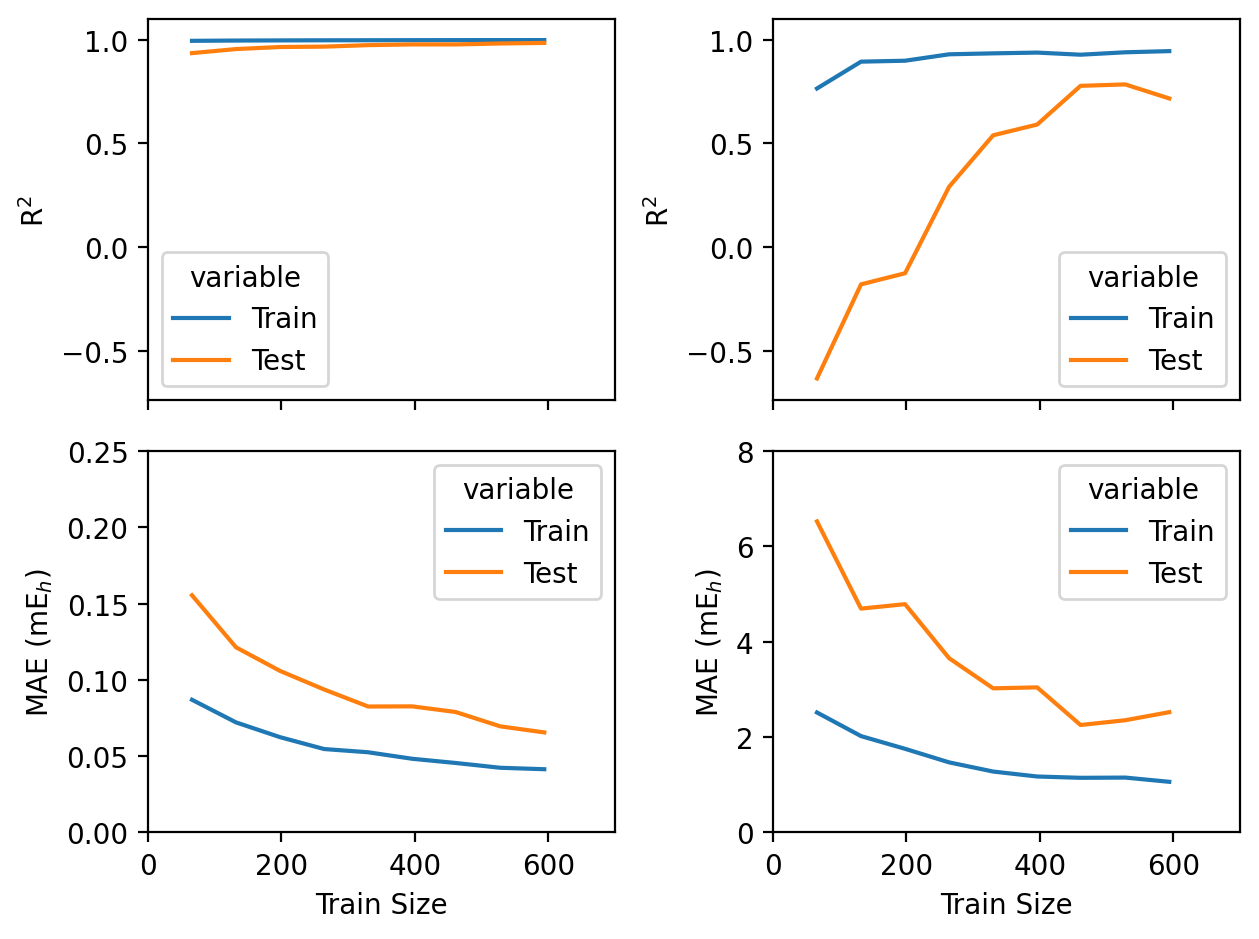

66 132
R2: 0.9940,0.9182
RMSE (mEh): 0.1598,0.5939
132 132
R2: 0.9959,0.9261
RMSE (mEh): 0.1328,0.5645
198 132
R2: 0.9968,0.9472
RMSE (mEh): 0.1179,0.4773
264 132
R2: 0.9972,0.9637
RMSE (mEh): 0.1105,0.3957
330 132
R2: 0.9976,0.9690
RMSE (mEh): 0.1007,0.3659
396 132
R2: 0.9979,0.9745
RMSE (mEh): 0.0947,0.3318
461 132
R2: 0.9981,0.9793
RMSE (mEh): 0.0916,0.2986
528 132
R2: 0.9982,0.9839
RMSE (mEh): 0.0888,0.2639


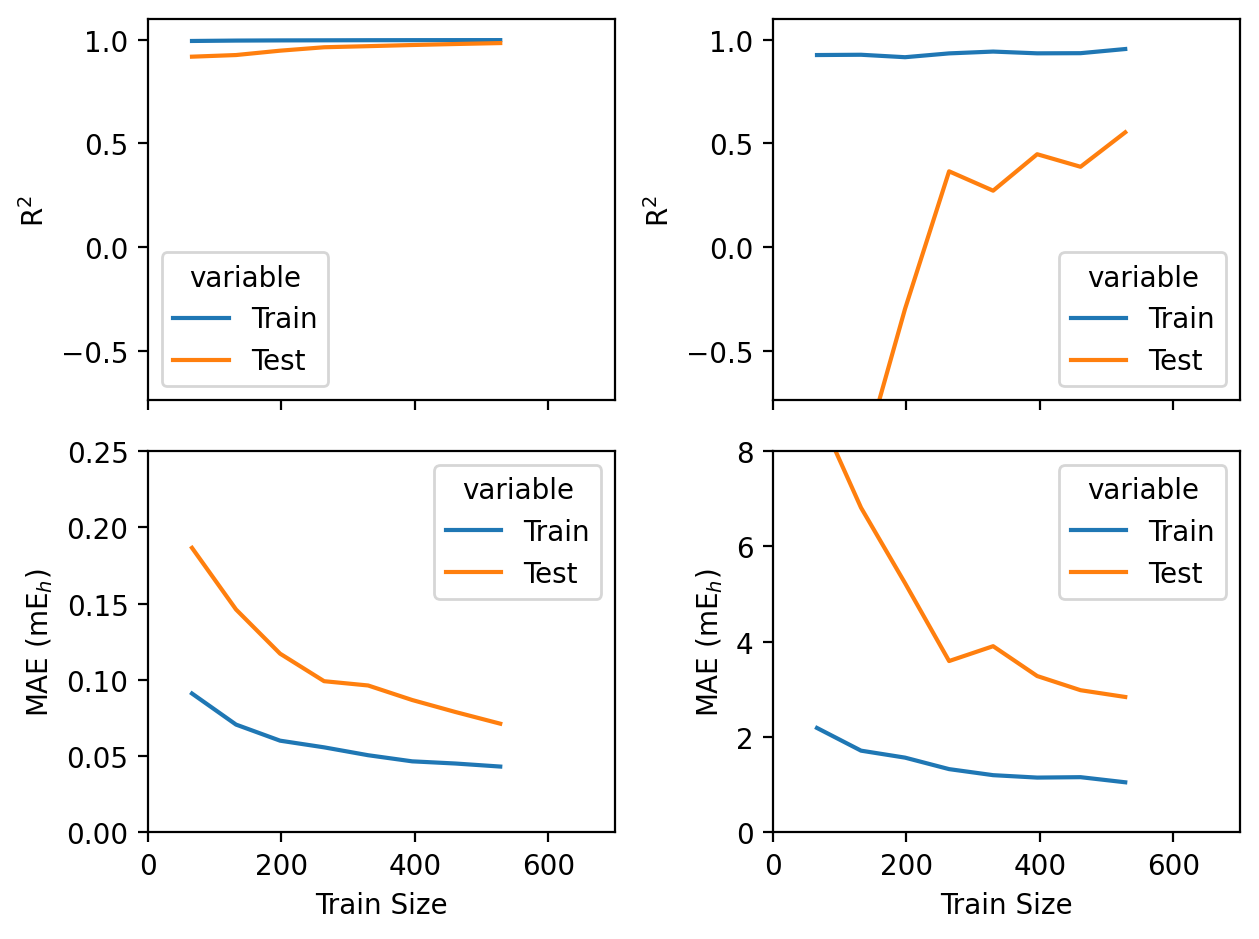

66 198
R2: 0.9945,0.8444
RMSE (mEh): 0.1542,0.8171
132 198
R2: 0.9960,0.9026
RMSE (mEh): 0.1306,0.6467
198 198
R2: 0.9968,0.9437
RMSE (mEh): 0.1169,0.4914
264 198
R2: 0.9974,0.9383
RMSE (mEh): 0.1056,0.5144
330 198
R2: 0.9976,0.9599
RMSE (mEh): 0.1012,0.4149
396 198
R2: 0.9979,0.9602
RMSE (mEh): 0.0951,0.4134
461 198
R2: 0.9980,0.9669
RMSE (mEh): 0.0927,0.3767


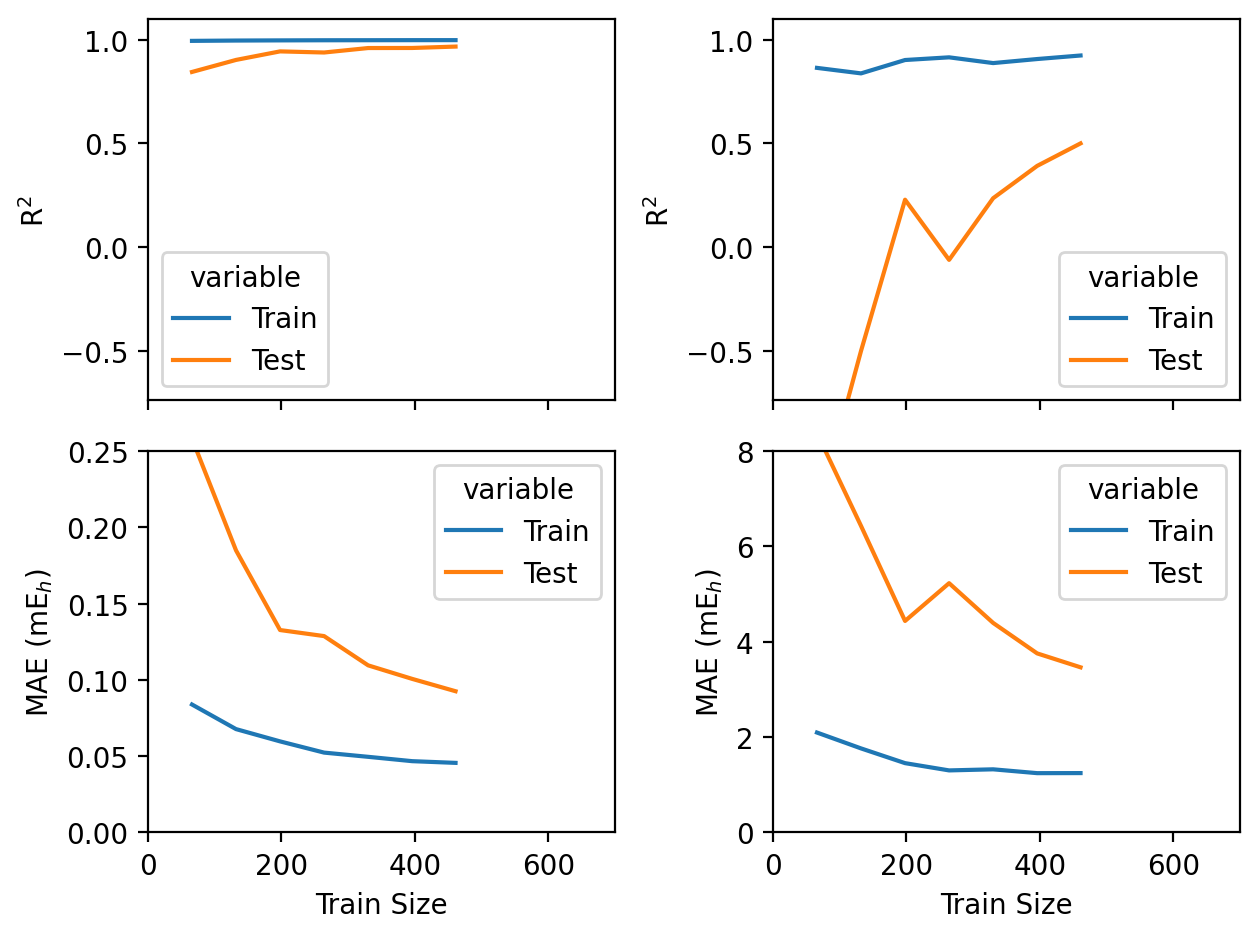

66 264
R2: 0.9945,0.8629
RMSE (mEh): 0.1532,0.7673
132 264
R2: 0.9960,0.9385
RMSE (mEh): 0.1306,0.5141
198 264
R2: 0.9971,0.9344
RMSE (mEh): 0.1119,0.5307
264 264
R2: 0.9975,0.9530
RMSE (mEh): 0.1043,0.4494
330 264
R2: 0.9978,0.9609
RMSE (mEh): 0.0977,0.4099
396 264
R2: 0.9979,0.9677
RMSE (mEh): 0.0951,0.3721


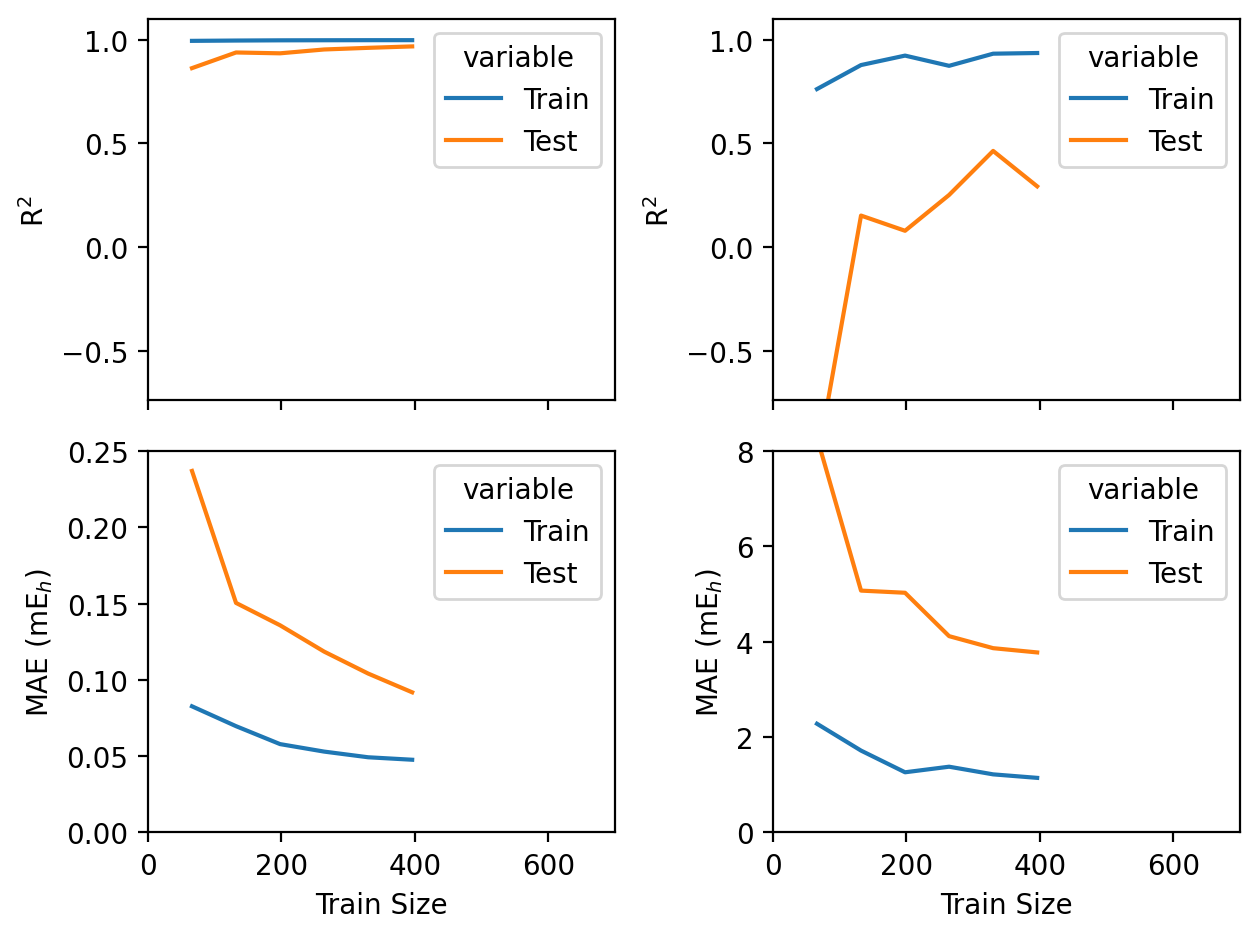

66 330
R2: 0.9946,0.9070
RMSE (mEh): 0.1531,0.6321
132 330
R2: 0.9964,0.9360
RMSE (mEh): 0.1244,0.5245
198 330
R2: 0.9972,0.9508
RMSE (mEh): 0.1104,0.4597
264 330
R2: 0.9976,0.9647
RMSE (mEh): 0.1029,0.3892
330 330
R2: 0.9978,0.9646
RMSE (mEh): 0.0975,0.3897


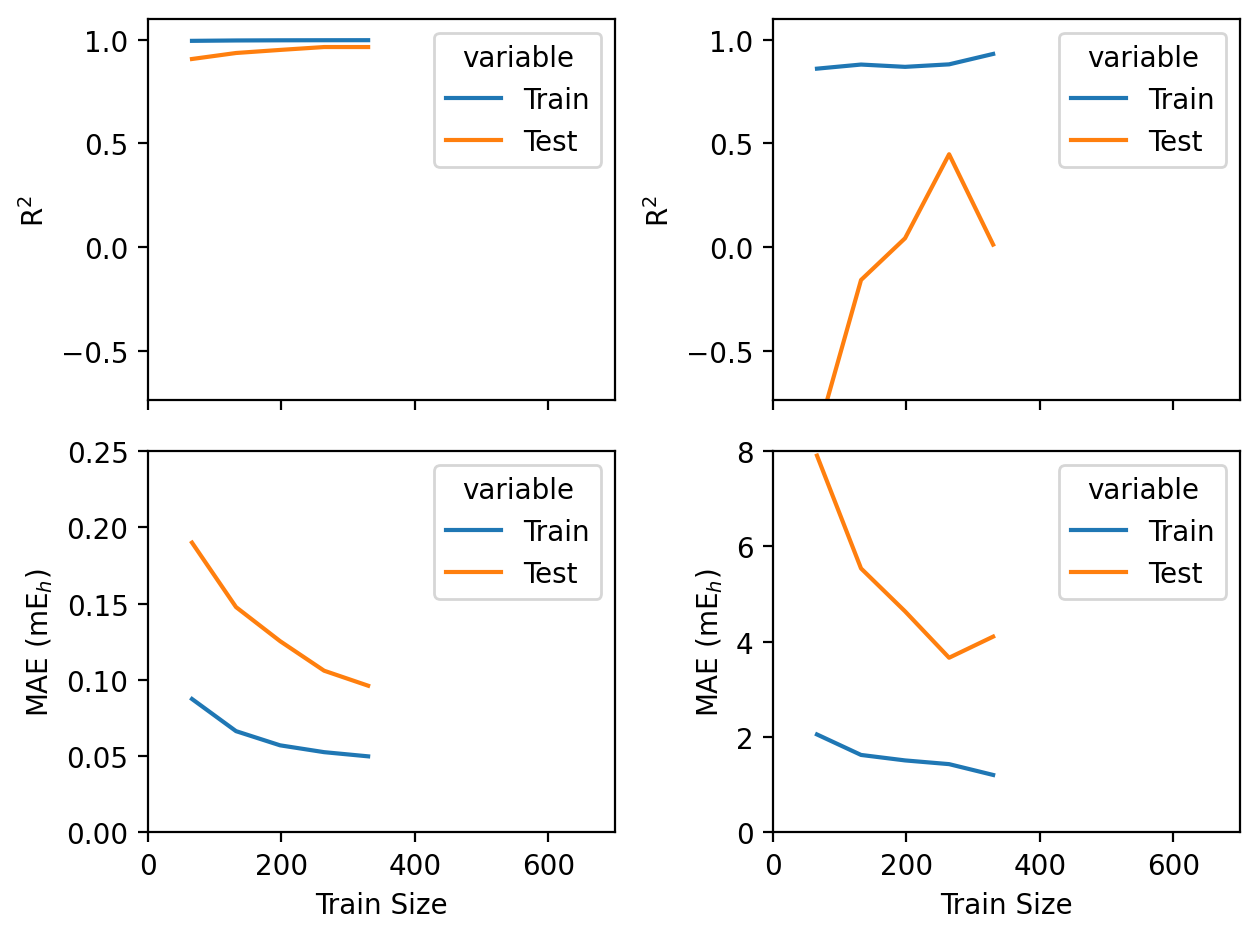

66 396
R2: 0.9953,0.8597
RMSE (mEh): 0.1424,0.7768
132 396
R2: 0.9966,0.9145
RMSE (mEh): 0.1214,0.6066
198 396
R2: 0.9972,0.9432
RMSE (mEh): 0.1100,0.4944
264 396
R2: 0.9976,0.9555
RMSE (mEh): 0.1016,0.4377


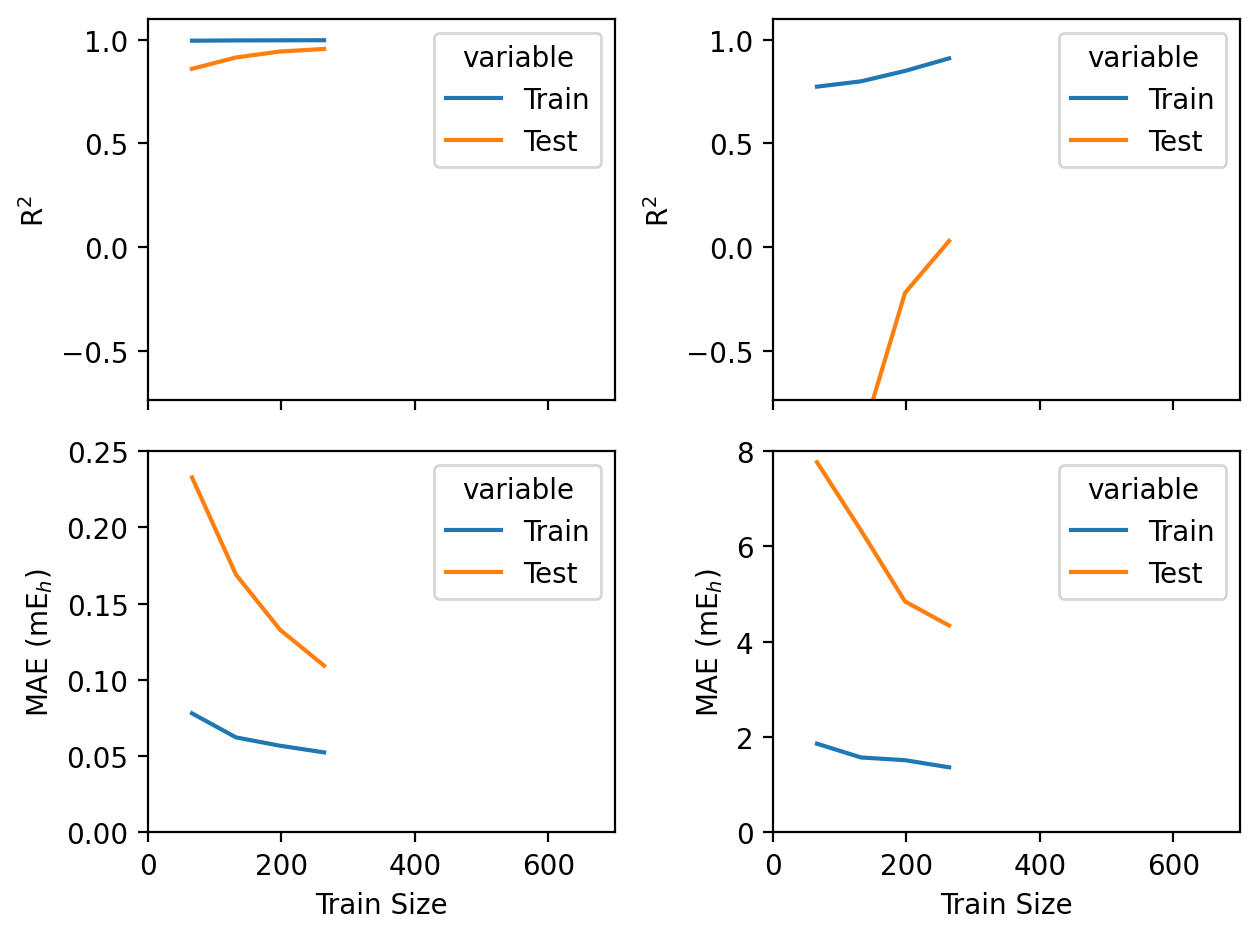

66 462
R2: 0.9952,0.8805
RMSE (mEh): 0.1439,0.7176
132 462
R2: 0.9966,0.9275
RMSE (mEh): 0.1222,0.5589
198 462
R2: 0.9970,0.9520
RMSE (mEh): 0.1143,0.4549


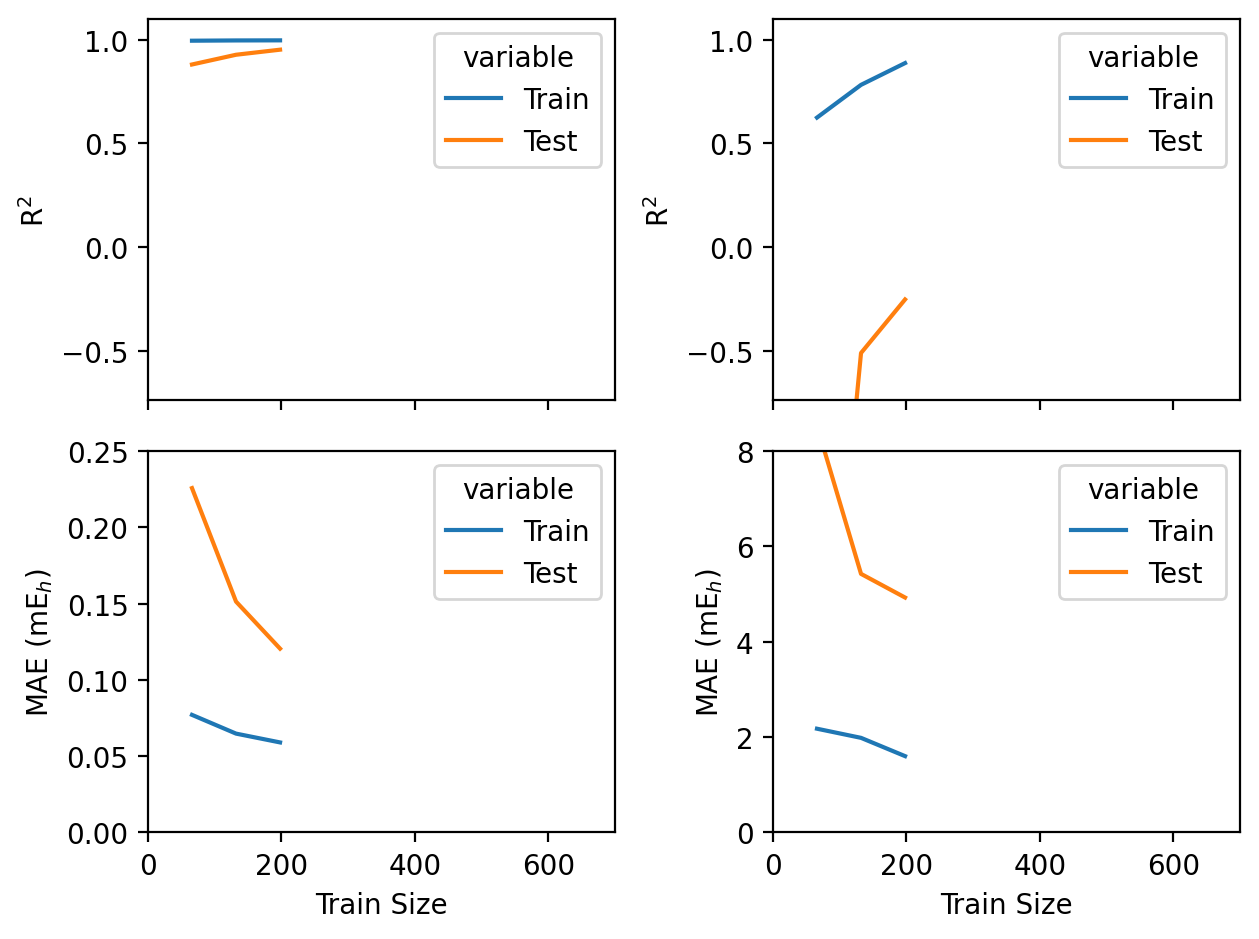

66 528
R2: 0.9951,0.9021
RMSE (mEh): 0.1452,0.6501
132 528
R2: 0.9964,0.9335
RMSE (mEh): 0.1250,0.5356


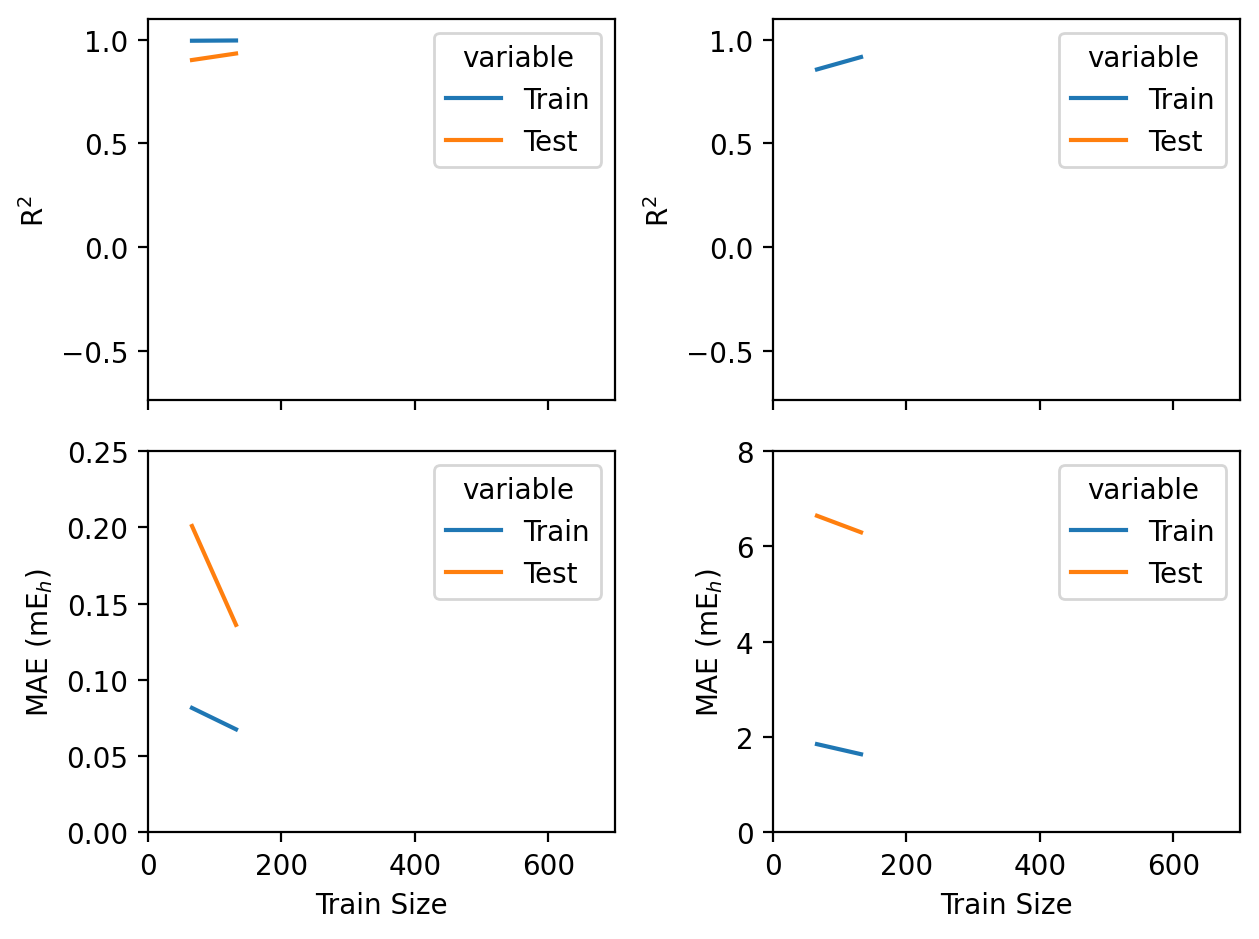

66 594
R2: 0.9949,0.8992
RMSE (mEh): 0.1483,0.6596


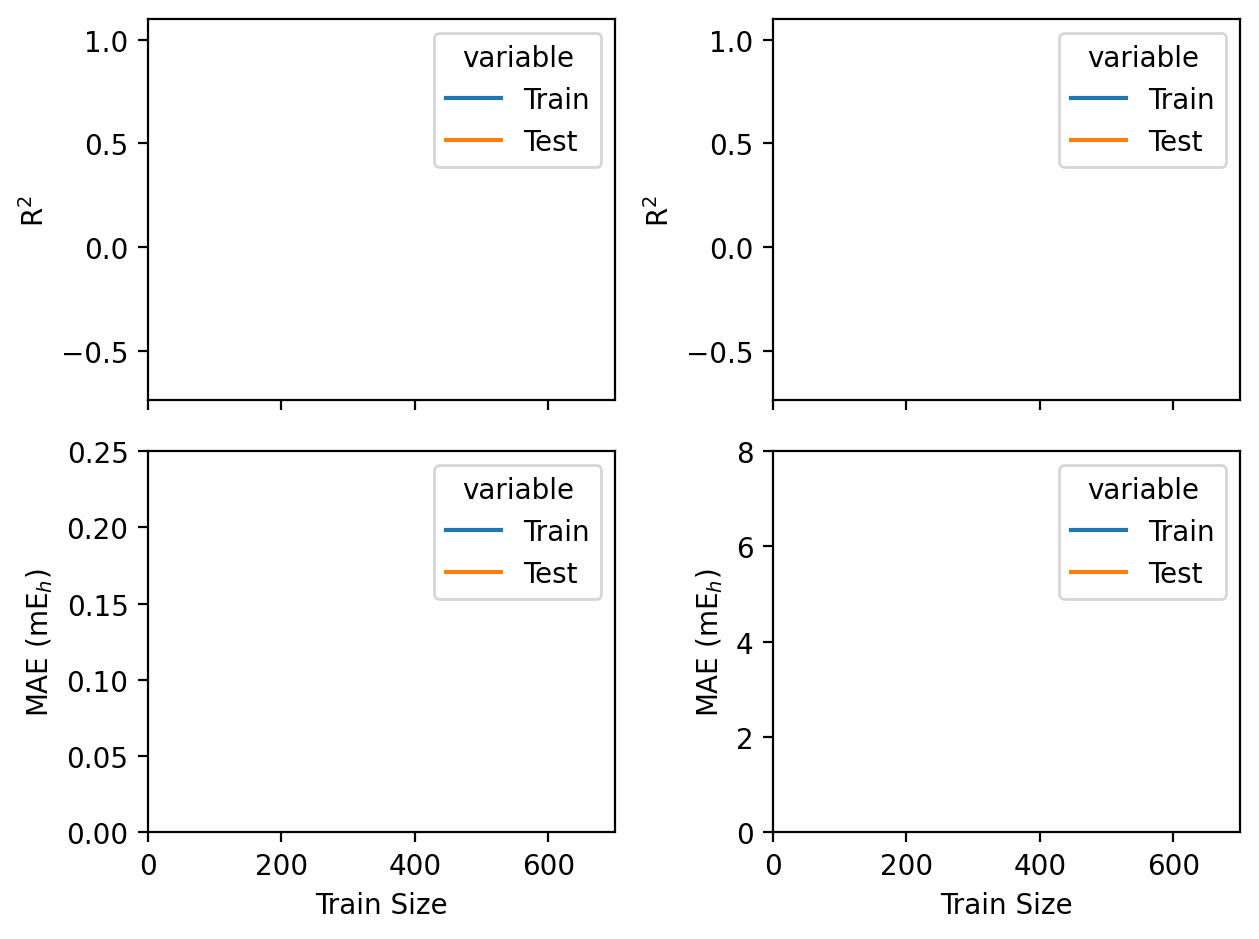

In [5]:

ranges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
for j in ranges:
    data = []
    for i in ranges:
        if j+i<=1:
            # print(i,j)
            data.append((int(i * datanums),gen_lc(i,j)))
    plot(data,j)
    plt.show()
    


In [7]:
def gen_cut(cutoff):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]
        
    radius_range_dirs = []
    for i in glob('cluster/*.*'):
        try:
            radstr = float(os.path.basename(i))
            # if radstr>=1.4:
            radius_range_dirs.append(os.path.basename(i))
        except:
            continue
    
    radius_range = sorted(radius_range_dirs)
    
    train_ind,test_ind=radius_range[0::2],radius_range[1::2]
    
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind, test_size=0.1, random_state=42)
    
    print(len(train_ind),len(test_ind))
    
    
    train = []
    test = []
    
    
    
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    
    
    for k in train_ind:
        rad = f"{k:.2f}"
        traindf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        traindf = traindf[traindf['Pair_Energies'].abs()>=cutoff]
        train.append(traindf)
        recover_train.append((rad,traincnt,len(traindf)))
        traincnt+=1
            
    for l in test_ind:
        rad = f"{l:.2f}"
        testdf = pd.read_csv(os.path.join('cluster',rad,f'{rad}.csv'),compression='zip',index_col=0)
        testdf = testdf[testdf['Pair_Energies'].abs()>=cutoff]
        test.append(testdf)                    
        recover_test.append((rad,testcnt,len(testdf)))
        testcnt+=1
    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': 'h$_{p}^{0}$',
    'h$_{pp}^{1}$': 'h$_{p}^{1}$',
    'h$_{pp}^{2}$': 'h$_{p}^{2}$',
    'h$_{pp}^{3}$': 'h$_{p}^{3}$',
    'h$_{rr}^{0}$': 'h$_{r}^{0}$',
    'h$_{rr}^{1}$': 'h$_{r}^{1}$',
    'h$_{rr}^{2}$': 'h$_{r}^{2}$',
    'h$_{rr}^{3}$': 'h$_{r}^{3}$'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    
    kwargs = dict(pd.read_excel("iron_VDZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:'Radius ($\AA$)',1:'E$_{2}^{\text{Calculated}}$',2:'E$_{2}^{\text{Predicted}}$'}).set_index('Radius ($\AA$)')
    #.astype({"basis set":str,'Radius ($\AA$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    
    
    for i in traincorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    
    
    for i in testcorrE2.index:
        energy_df = pd.read_excel(f"cluster/{i}/{i}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    testcorrE2.reset_index(inplace=True)
    traincorrE2.reset_index(inplace=True)    
    
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [8]:
14-3

11

In [9]:
data = []
for i in np.logspace(-14,-3,12):
    print(i)
    data.append((i,gen_cut(i)))


pair_r2 = []
pair_mae = []
corr_r2 = []
corr_mae = []
for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
    traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
    traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']

    testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
    testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
    pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))

    corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
    corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))

dfpair_r2 = pd.DataFrame(pair_r2,columns=['Cutoff', "Train", "Test"])
dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Cutoff', "Train", "Test"])
dfpair_mae = pd.DataFrame(pair_mae,columns=['Cutoff', "Train", "Test"])
dfcorr_mae = pd.DataFrame(corr_mae,columns=['Cutoff', "Train", "Test"])




1e-14
594 66
R2: 0.9983,0.9846
RMSE (mEh): 0.0856,0.2588
1e-13
594 66
R2: 0.9983,0.9851
RMSE (mEh): 0.0865,0.2549
1e-12
594 66
R2: 0.9983,0.9849
RMSE (mEh): 0.0858,0.2565
1e-11
594 66
R2: 0.9983,0.9845
RMSE (mEh): 0.0867,0.2596
1e-10
594 66
R2: 0.9983,0.9862
RMSE (mEh): 0.0868,0.2455
1e-09
594 66
R2: 0.9983,0.9839
RMSE (mEh): 0.0866,0.2646
1e-08
594 66
R2: 0.9983,0.9865
RMSE (mEh): 0.0867,0.2429
1e-07
594 66
R2: 0.9983,0.9829
RMSE (mEh): 0.0871,0.2752
1e-06
594 66
R2: 0.9982,0.9819
RMSE (mEh): 0.0892,0.2886
9.999999999999999e-06
594 66
R2: 0.9982,0.9781
RMSE (mEh): 0.0961,0.3432
0.0001
594 66
R2: 0.9983,0.9845
RMSE (mEh): 0.1079,0.3307
0.001
594 66
R2: 0.9983,0.9831
RMSE (mEh): 0.1206,0.3878


In [10]:
dfpair_r2

,Cutoff,Train,Test
0,1.000000e-14,0.998298,0.984600
1,1.000000e-13,0.998264,0.985065
2,1.000000e-12,0.998290,0.984868
3,1.000000e-11,0.998255,0.984509
4,1.000000e-10,0.998253,0.986160
5,1.000000e-09,0.998261,0.983939
6,1.000000e-08,0.998264,0.986518
7,1.000000e-07,0.998268,0.982926
8,1.000000e-06,0.998248,0.981899
9,1.000000e-05,0.998246,0.978115


/tmp/ipykernel_324490/3291187885.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0][0].set_xlim(10**-15,0)


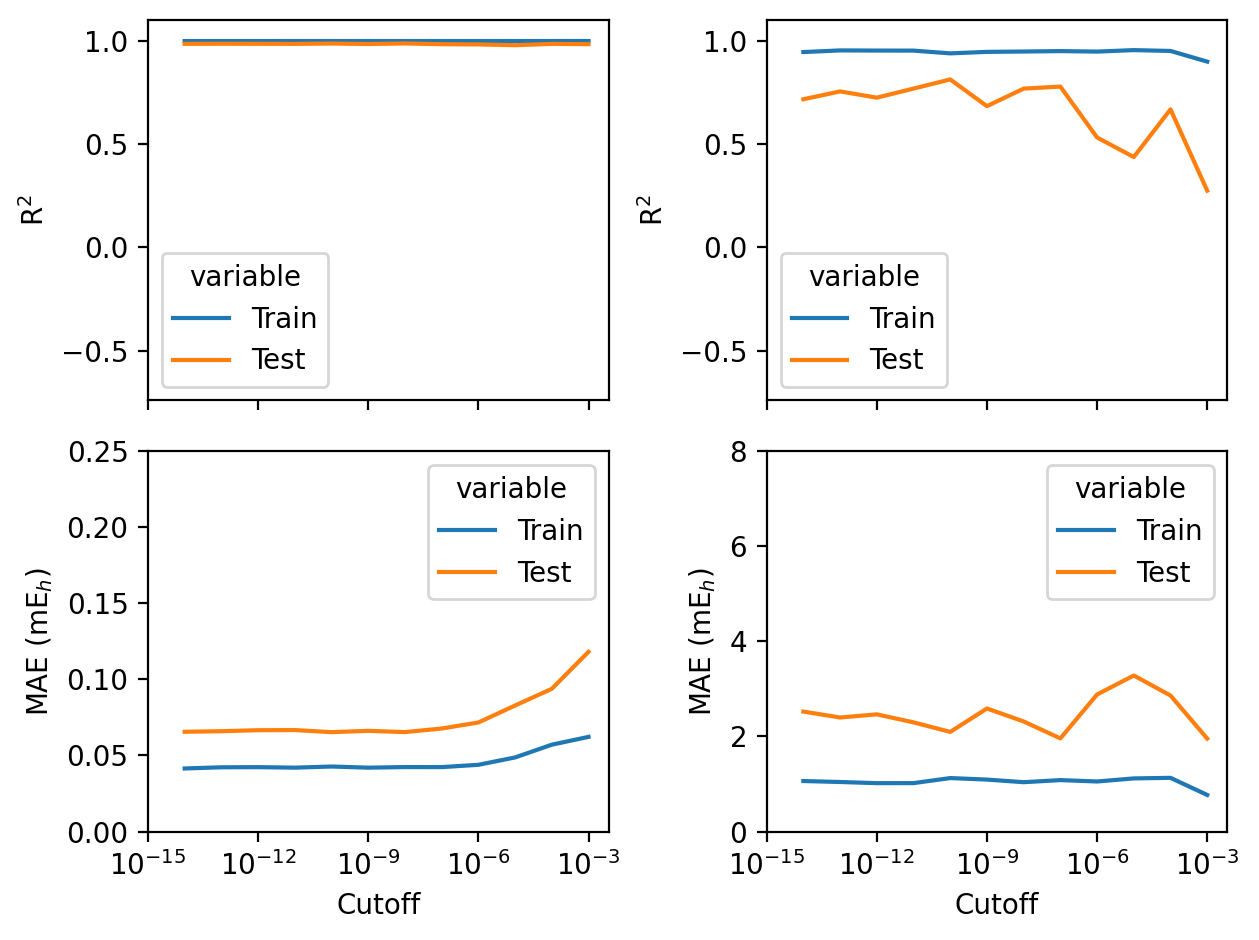

In [11]:
fig, ax = plt.subplots(2,2,sharex=True)
sns.lineplot(dfpair_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][0])
sns.lineplot(dfcorr_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][1],markers='x')
# ax[0][0].set_xlim(0,700)
# ax[0][1].set_xlim(0,700)
ax[0][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[0][0].set_ylim(-.74,1.1)
ax[0][1].set_ylim(-.74,1.1)
ax[0][0].set_xlim(10**-15,0)
# ax[0][1].set_xlim(-.74,1.1)
ax[0][0].set_ylabel("R$^{2}$")
ax[0][1].set_ylabel("R$^{2}$")
sns.lineplot(dfpair_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][0])
ax[1][0].set_ylim(0,0.25)
sns.lineplot(dfcorr_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][1])
ax[1][1].set_ylim(0,8)
ax[1][0].set_ylabel("MAE (mE$_{h}$)")
ax[1][1].set_ylabel("MAE (mE$_{h}$)")
plt.tight_layout()
plt.savefig('images/cutoff_curves.png',dpi=300,bbox_inches='tight')

In [12]:
dfcorr_r2.sort_values(by=['Train','Test'])

,Cutoff,Train,Test
11,1.000000e-03,0.898651,0.274435
4,1.000000e-10,0.938585,0.812475
0,1.000000e-14,0.944962,0.716611
5,1.000000e-09,0.945856,0.683280
8,1.000000e-06,0.947220,0.531833
6,1.000000e-08,0.947555,0.768133
7,1.000000e-07,0.949543,0.777916
10,1.000000e-04,0.950319,0.667676
3,1.000000e-11,0.951949,0.768258
2,1.000000e-12,0.952143,0.724407
